In [26]:
import numpy as np
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import matplotlib_inline 
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split

from torch.utils.data import  DataLoader ,TensorDataset
import seaborn as sns

In [27]:
iris = sns.load_dataset("iris")

In [28]:
# convert pandas to tensor
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float)

# label encoding
labels = torch.zeros(data.shape[0],dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [29]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

batchSize = 64
train_loader = DataLoader(train_data,shuffle=True,batch_size=batchSize,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [30]:
def createNet():
    
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )
    
    
    lossFn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005)
    
    return ANNiris,lossFn,optimizer

In [31]:
# explore the model in more detail
tmpModel = createNet()[0]

# model architecture
print(tmpModel)

# print model parameters
for i in tmpModel.named_parameters():
    print(i[0],i[1].shape,i[1].numel())


Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [32]:

num_epochs = 1000

def trainNet(L1lambda):
    
    # init accurascies as empties
    trainAcc = []
    testAcc = []
    losses = []
    # count the total number of weights in the model
    nWeight = 0
    for pName,weight in ANNiris.named_parameters():
                if "bias" not in pName:
                    nWeight += weight.numel()
    
    
    for epochI in range(num_epochs):
        
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            yHat = ANNiris(X)
            loss = lossFn(yHat,y)
            
            
            ### add L1 term
            L1_term = torch.tensor(0.,requires_grad=True)
            
            # sum up all abs(weights)
            for pName,weight in ANNiris.named_parameters():
                if "bias" not in pName:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
            
            loss = loss + L1lambda*L1_term/nWeight
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            batchAcc.append(100*torch.mean((torch.argmax(yHat,dim=1) == y).float()).item())
            batchLoss.append(loss.item())
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y = next(iter(test_loader))
        predLabels = torch.argmax(ANNiris(X),dim=1)
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
            
    return trainAcc,testAcc,losses 

In [33]:
ANNiris,lossFn,optimizer = createNet()

# train
L1lambda = .001
trainAcc,testAcc,losses = trainNet(L1lambda)

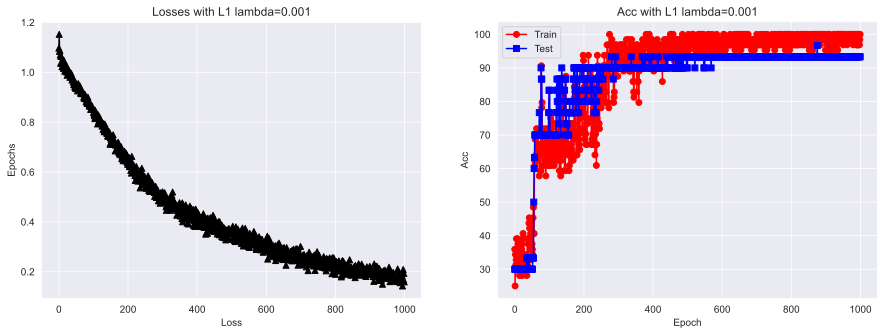

In [34]:
fig ,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses,'k^-')
ax[0].set_xlabel("Loss")
ax[0].set_ylabel("Epochs")
ax[0].set_title("Losses with L1 lambda=" + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Acc")
ax[1].set_title("Acc with L1 lambda=" + str(L1lambda))
ax[1].legend(["Train","Test"])

plt.show()

In [35]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,'same')

In [36]:
L1lambdas = np.linspace(0,.005,10)

accResTrain = np.zeros((num_epochs,len(L1lambdas)))
accResTest = np.zeros((num_epochs,len(L1lambdas)))

for lI in range(len(L1lambdas)):
    
    # create and train model
    ANNiris,lossFn,optimizer = createNet()
    trainAcc,testAcc,losses = trainNet(L1lambdas[lI])
    # store data
    accResTrain[:,lI] = smooth(trainAcc,10)
    accResTest[:,lI] = smooth(testAcc,10)


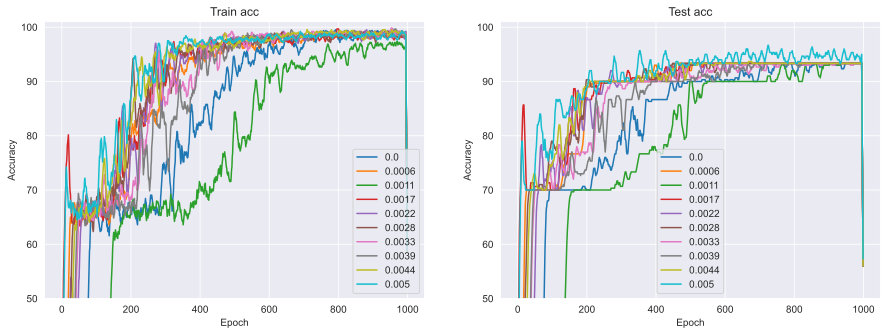

In [37]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(accResTrain)
ax[0].set_title("Train acc")
ax[1].plot(accResTest)
ax[1].set_title("Test acc")

legLabels = [np.round(i,4) for i in L1lambdas]

for i in range(2):
    ax[i].legend(legLabels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_ylim([50,101])
    # ax[i].grid()
    
plt.show()

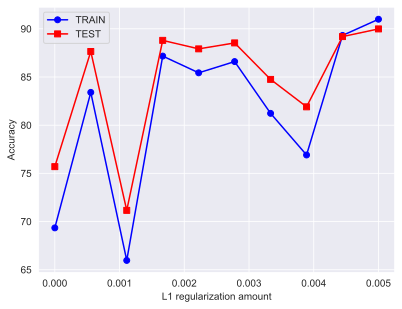

In [38]:
# show avarage acc by L2 rate

epoch_range = [160,360]

plt.plot(L1lambdas,
         np.mean(accResTrain[epoch_range[0]:epoch_range[1],:],axis=0),'bo-',label='TRAIN')

plt.plot(L1lambdas,
         np.mean(accResTest[epoch_range[0]:epoch_range[1],:],axis=0),'rs-',label='TEST')

plt.xlabel("L1 regularization amount")
plt.ylabel("Accuracy")
plt.legend()
plt.show()